In [31]:
# Cell 1 — imports & options
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
pd.options.future.infer_string = True

In [32]:
# Returns most frequent value in a Series (used to fill categorical modes).
def simple_mode(s: pd.Series):
    m = s.mode(dropna=True)
    return m.iloc[0] if len(m) else np.nan

# Clips negative numeric values (area/count columns) to zero.
def enforce_nonnegative(df: pd.DataFrame) -> pd.DataFrame:
    """Clip logical non-negative numerics at 0 (defensive net)."""
    nonneg = [
        'Lot Area','Lot Frontage','Gr Liv Area',
        'BsmtFin SF 1','BsmtFin SF 2','Bsmt Unf SF','Total Bsmt SF',
        'Garage Area','Garage Cars','1st Flr SF','2nd Flr SF','Low Qual Fin SF',
        'Wood Deck SF','Open Porch SF','Enclosed Porch','3Ssn Porch','Screen Porch',
        'Pool Area','SalePrice'
    ]
    for c in nonneg:
        if c in df.columns:
            df[c] = df[c].clip(lower=0)
    return df

def normalize_categoricals(df: pd.DataFrame) -> pd.DataFrame:
    """Trim/standardize string categories (avoids hidden ‘NaN ’, ‘ y ’, etc.)."""
    obj_cols = df.select_dtypes(include='object').columns
    for c in obj_cols:
        df[c] = df[c].astype(str).str.strip()
        df.loc[df[c].isin(['', 'nan', 'None', 'NaT']), c] = np.nan
    # Central Air should be Y/N
    if 'Central Air' in df.columns:
        df['Central Air'] = df['Central Air'].replace({'Yes': 'Y', 'No': 'N', 'y': 'Y', 'n': 'N'})
    return df

def apply_absence_labels(df: pd.DataFrame) -> pd.DataFrame:
    na_none_map = {
        'Alley': 'NoAlley',
        'Bsmt Qual': 'NoBasement','Bsmt Cond': 'NoBasement','Bsmt Exposure': 'NoBasement',
        'BsmtFin Type 1': 'NoBasement','BsmtFin Type 2': 'NoBasement',
        'Fireplace Qu': 'NoFireplace',
        'Garage Type': 'NoGarage','Garage Finish': 'NoGarage','Garage Qual': 'NoGarage','Garage Cond': 'NoGarage',
        'Pool QC': 'NoPool','Fence': 'NoFence','Misc Feature': 'NoFeature'
    }
    for col, val in na_none_map.items():
        if col in df.columns:
            df[col] = df[col].replace('NA', val).fillna(val)
    return df

def fix_basement_consistency(df: pd.DataFrame) -> pd.DataFrame:
    parts = ['BsmtFin SF 1','BsmtFin SF 2','Bsmt Unf SF']; total = 'Total Bsmt SF'
    has_bsmt_area = (df[parts].fillna(0).sum(axis=1) > 0)
    bad_expo = has_bsmt_area & (df['Bsmt Exposure'] == 'NoBasement')
    df['Fix_BsmtExposure'] = 0
    df.loc[bad_expo, 'Bsmt Exposure'] = 'No'
    df.loc[bad_expo, 'Fix_BsmtExposure'] = 1

    sum_parts = df[parts].fillna(0).sum(axis=1)
    all_parts_na = df[parts].isna().all(axis=1)
    total_na = df[total].isna()

    mask_true_mismatch = (~all_parts_na) & (~total_na) & (df[total] != sum_parts)
    mask_total_missing = (~all_parts_na) & total_na
    df.loc[mask_true_mismatch, total] = sum_parts[mask_true_mismatch]
    df.loc[mask_total_missing, total] = sum_parts[mask_total_missing]

    mask_parts_missing = all_parts_na & (~total_na)
    for c in parts:
        df.loc[mask_parts_missing, c] = df.loc[mask_parts_missing, c].fillna(0)

    mask_all_missing = all_parts_na & total_na & (df['Bsmt Qual'] == 'NoBasement')
    for c in parts + [total]:
        df.loc[mask_all_missing, c] = 0
    return df

def consolidate_garage_absence(df: pd.DataFrame) -> pd.DataFrame:
    """If no garage (type/area/cars imply absence), zero numerics + set labels to NoGarage."""
    g_zero = (df.get('Garage Cars', 0).fillna(0) == 0) & (df.get('Garage Area', 0).fillna(0) == 0)
    if 'Garage Type' in df.columns:
        g_abs = (df['Garage Type'] == 'NoGarage') | g_zero
        for c in ['Garage Finish','Garage Qual','Garage Cond','Garage Type']:
            if c in df.columns:
                df.loc[g_abs, c] = 'NoGarage'
        for c in ['Garage Yr Blt','Garage Area','Garage Cars']:
            if c in df.columns:
                df.loc[g_abs, c] = 0
    return df

def apply_time_filters(df: pd.DataFrame) -> pd.DataFrame:
    df = df[(df['Yr Sold'] >= df['Year Built']) & (df['Yr Sold'] >= df['Year Remod/Add'])].copy()
    df = df[df['Year Remod/Add'] >= df['Year Built']].copy()
    mask_gyear_ok = (~df['Garage Yr Blt'].notna()) | (
        (df['Garage Yr Blt'] >= 1880) & (df['Garage Yr Blt'] <= (df['Yr Sold'] + 1))
    )
    return df[mask_gyear_ok].copy()

def add_binary_flags(df: pd.DataFrame) -> pd.DataFrame:
    df['HasPool']   = (df['Pool Area'] > 0).astype(int)
    df['HasFire']   = (df['Fireplaces'] > 0).astype(int)
    df['HasAC']     = (df['Central Air'] == 'Y').astype(int)
    df['HasFence']  = (df['Fence'] != 'NoFence').astype(int)
    df['HasGarage'] = (df['Garage Cars'].fillna(0) > 0).astype(int)
    df['AmenitiesCount'] = df[['HasPool','HasFire','HasAC','HasFence','HasGarage']].sum(axis=1)
    return df

def drop_low_signal_columns(df: pd.DataFrame) -> pd.DataFrame:
    to_drop = ['Utilities','Street','Condition 2','Roof Matl','Heating','Pool QC','Misc Feature','Garage Cond']
    keep = [c for c in to_drop if c in df.columns]
    return df.drop(columns=keep).copy()

def ordinal_encode_inplace(df: pd.DataFrame) -> pd.DataFrame:
    ord_orders = {
        'Exter Qual':['Po','Fa','TA','Gd','Ex'],'Exter Cond':['Po','Fa','TA','Gd','Ex'],
        'Bsmt Qual':['NoBasement','Po','Fa','TA','Gd','Ex'],'Bsmt Cond':['NoBasement','Po','Fa','TA','Gd','Ex'],
        'Bsmt Exposure':['NoBasement','No','Mn','Av','Gd'],
        'BsmtFin Type 1':['NoBasement','Unf','LwQ','Rec','BLQ','ALQ','GLQ'],
        'BsmtFin Type 2':['NoBasement','Unf','LwQ','Rec','BLQ','ALQ','GLQ'],
        'Heating QC':['Po','Fa','TA','Gd','Ex'],'Electrical':['FuseP','FuseF','Mix','FuseA','SBrkr'],
        'Kitchen Qual':['Po','Fa','TA','Gd','Ex'],'Fireplace Qu':['NoFireplace','Po','Fa','TA','Gd','Ex'],
        'Garage Finish':['NoGarage','Unf','RFn','Fin'],'Garage Qual':['NoGarage','Po','Fa','TA','Gd','Ex'],
        'Paved Drive':['N','P','Y'],'Lot Shape':['IR3','IR2','IR1','Reg'],'Land Slope':['Sev','Mod','Gtl'],
    }
    for col, order in ord_orders.items():
        if col in df.columns:
            cat = pd.Categorical(df[col], categories=order, ordered=True)
            s = pd.Series(cat.codes, index=df.index).astype('float64')
            s[s == -1] = np.nan
            df[col] = s
    return df

def bucket_rare(df: pd.DataFrame, cols: list, min_count: int = 5) -> pd.DataFrame:
    for c in cols:
        if c in df.columns:
            s = df[c].astype(str)  # TODO check--> edge case
            vc = df[c].value_counts(dropna=False)
            rare = set(vc[vc < min_count].index)
            df[c] = df[c].where(~df[c].isin(rare), "__Other__")
    return df


In [33]:
def compute_train_stats(df_tr: pd.DataFrame):
    stats = {}
    if 'Lot Frontage' in df_tr.columns and 'Neighborhood' in df_tr.columns:
        stats['lf_med_nb']   = df_tr.groupby('Neighborhood')['Lot Frontage'].median()
        stats['lf_med_glob'] = df_tr['Lot Frontage'].median()
    else:
        stats['lf_med_nb'] = pd.Series(dtype='float64'); stats['lf_med_glob'] = np.nan

    label_cols_all = ['Garage Finish','Garage Qual','Garage Cond']
    label_cols = [c for c in label_cols_all if c in df_tr.columns]
    g_has_tr = (
        (df_tr.get('Garage Type', 'NoGarage') != 'NoGarage') |
        (df_tr.get('Garage Area', pd.Series(0, index=df_tr.index)).fillna(0) > 0) |
        (df_tr.get('Garage Cars', pd.Series(0, index=df_tr.index)).fillna(0) > 0)
    )
    if 'Garage Type' in df_tr.columns and any(label_cols):
        try:
            stats['g_modes_by_type'] = df_tr[g_has_tr].groupby('Garage Type')[label_cols].agg(simple_mode)
        except Exception:
            stats['g_modes_by_type'] = pd.DataFrame()
    else:
        stats['g_modes_by_type'] = pd.DataFrame()

    stats['g_med_area_by_type'] = (df_tr[g_has_tr].groupby('Garage Type')['Garage Area'].median()
                                   if {'Garage Type','Garage Area'} <= set(df_tr.columns) else pd.Series(dtype='float64'))
    stats['g_med_cars_by_type'] = (df_tr[g_has_tr].groupby('Garage Type')['Garage Cars'].median()
                                   if {'Garage Type','Garage Cars'} <= set(df_tr.columns) else pd.Series(dtype='float64'))

    if {'Mas Vnr Area','Mas Vnr Type'} <= set(df_tr.columns):
        ref = df_tr[(df_tr['Mas Vnr Area'].fillna(0) > 0) & df_tr['Mas Vnr Type'].notna() & (df_tr['Mas Vnr Type'] != 'None')]
        stats['mvt_nb_mode'] = (ref.groupby('Neighborhood')['Mas Vnr Type'].agg(simple_mode)
                                if 'Neighborhood' in df_tr.columns else pd.Series(dtype='object'))
        gmode = df_tr['Mas Vnr Type'].dropna().mode()
        stats['mvt_global_mode'] = gmode.iloc[0] if len(gmode) else 'BrkFace'
    else:
        stats['mvt_nb_mode'] = pd.Series(dtype='object'); stats['mvt_global_mode'] = 'BrkFace'

    num_cols = [c for c in df_tr.select_dtypes(include=[np.number]).columns if c != 'SalePrice']
    stats['num_medians'] = df_tr[num_cols].median(numeric_only=True)
    return stats

def apply_train_stats(df_block: pd.DataFrame, stats: dict) -> pd.DataFrame:
    if {'Lot Frontage','Neighborhood'} <= set(df_block.columns) and not pd.isna(stats.get('lf_med_glob', np.nan)):
        df_block['Lot Frontage'] = df_block['Lot Frontage'].fillna(df_block['Neighborhood'].map(stats['lf_med_nb'])).fillna(stats['lf_med_glob'])

    g_has = (
        (df_block.get('Garage Type', 'NoGarage') != 'NoGarage') |
        (df_block.get('Garage Area', pd.Series(0, index=df_block.index)).fillna(0) > 0) |
        (df_block.get('Garage Cars', pd.Series(0, index=df_block.index)).fillna(0) > 0)
    )
    if isinstance(stats.get('g_modes_by_type'), pd.DataFrame) and not stats['g_modes_by_type'].empty and 'Garage Type' in df_block.columns:
        need_fix = g_has & (
            (df_block.get('Garage Finish', pd.Series(np.nan, index=df_block.index)).isna()) |
            (df_block.get('Garage Qual',   pd.Series(np.nan, index=df_block.index)).isna()) |
            (df_block.get('Garage Cond',   pd.Series(np.nan, index=df_block.index)).isna()) |
            (df_block.get('Garage Finish', pd.Series('NoGarage', index=df_block.index)) == 'NoGarage') |
            (df_block.get('Garage Qual',   pd.Series('NoGarage', index=df_block.index)) == 'NoGarage') |
            (df_block.get('Garage Cond',   pd.Series('NoGarage', index=df_block.index)) == 'NoGarage')
        )
        for c in ['Garage Finish','Garage Qual','Garage Cond']:
            if c in df_block.columns and c in stats['g_modes_by_type'].columns:
                fill_vals = df_block.loc[need_fix, 'Garage Type'].map(stats['g_modes_by_type'][c])
                df_block.loc[need_fix, c] = df_block.loc[need_fix, c].fillna(fill_vals)

    if {'Garage Area','Garage Type'} <= set(df_block.columns) and not stats.get('g_med_area_by_type', pd.Series()).empty:
        m_area_na = g_has & df_block['Garage Area'].isna()
        df_block.loc[m_area_na, 'Garage Area'] = df_block.loc[m_area_na, 'Garage Type'].map(stats['g_med_area_by_type'])
    if {'Garage Cars','Garage Type'} <= set(df_block.columns) and not stats.get('g_med_cars_by_type', pd.Series()).empty:
        m_cars_na = g_has & df_block['Garage Cars'].isna()
        df_block.loc[m_cars_na, 'Garage Cars'] = df_block.loc[m_cars_na, 'Garage Type'].map(stats['g_med_cars_by_type'])

    if {'Mas Vnr Area','Mas Vnr Type'} <= set(df_block.columns):
        area = df_block['Mas Vnr Area']; typ = df_block['Mas Vnr Type']
        m_area0 = area.fillna(0) == 0; m_area_pos = area.fillna(0) > 0
        m_type_none = typ == 'None'; m_type_na = typ.isna()
        df_block.loc[m_type_na & m_area0, 'Mas Vnr Type'] = 'None'
        df_block.loc[(~m_type_none & ~m_type_na) & m_area0, 'Mas Vnr Type'] = 'None'
        mask_pos_missing = m_area_pos & (m_type_none | m_type_na)
        nb_mode = stats.get('mvt_nb_mode', pd.Series(dtype='object')); global_mode = stats.get('mvt_global_mode', 'BrkFace')
        if not nb_mode.empty and 'Neighborhood' in df_block.columns:
            nb_fill = df_block.loc[mask_pos_missing, 'Neighborhood'].map(nb_mode).fillna(global_mode)
        else:
            nb_fill = pd.Series(global_mode, index=df_block.index).loc[mask_pos_missing]
        df_block.loc[mask_pos_missing, 'Mas Vnr Type'] = nb_fill
    return df_block

def fill_not_present_numerics(df_block: pd.DataFrame) -> pd.DataFrame:
    exist_num = ['Garage Yr Blt','Garage Area','Garage Cars',
                 'BsmtFin SF 1','BsmtFin SF 2','Bsmt Unf SF','Total Bsmt SF',
                 'Bsmt Full Bath','Bsmt Half Bath','Pool Area','Mas Vnr Area']
    for c in exist_num:
        if c in df_block.columns:
            df_block[f'{c}_was_missing'] = df_block[c].isna().astype(int)
            df_block[c] = df_block[c].fillna(0)
    return df_block

def fill_remaining_numerics_with_train_median(df_block: pd.DataFrame, num_medians: pd.Series) -> pd.DataFrame:
    for c in df_block.select_dtypes(include=[np.number]).columns:
        if df_block[c].isna().any():
            df_block[c] = df_block[c].fillna(num_medians.get(c, df_block[c].median()))
    return df_block

In [34]:
def generate_sanity_report(df_raw, df_train_clean, df_test_clean, meta, make_plots=True):
    df_clean_all = pd.concat([df_train_clean, df_test_clean], ignore_index=True)
    n_raw = meta.get('n_raw', len(df_raw)); n_after_time = meta.get('n_after_time', len(df_clean_all))
    dropped_time = n_raw - n_after_time; pct_dropped = (dropped_time / n_raw) * 100 if n_raw else 0
    print("=== Sanity report ===")
    print(f"- Rows initiale: {n_raw}")
    print(f"- După filtre temporale: {n_after_time}  (drop: {dropped_time} | {pct_dropped:.2f}%)")
    n_fix_bsmt = meta.get('n_fix_bsmt_exposure', int(df_clean_all.get('Fix_BsmtExposure', pd.Series(0)).sum()))
    print(f"- Corecții Bsmt Exposure (NoBasement -> No când există arii): {n_fix_bsmt}")

    parts = ['BsmtFin SF 1','BsmtFin SF 2','Bsmt Unf SF']; total = 'Total Bsmt SF'
    if all(c in df_clean_all.columns for c in parts+[total]):
        mismatch = (df_clean_all[total] != df_clean_all[parts].fillna(0).sum(axis=1)).sum()
        print(f"- Identități subsol (Total == sum(parts)) → mismatches: {mismatch}")
    else:
        print("- Identități subsol: coloane lipsă, skip.")

    na_raw = df_raw.isna().sum().sort_values(ascending=False)
    na_clean = df_clean_all.isna().sum().sort_values(ascending=False)
    print("\nTop 10 coloane cu NaN (înainte):"); print(na_raw.head(10))
    print("\nTop 10 coloane cu NaN (după curățare):"); print(na_clean.head(10))
    print(f"\nShapes: train={df_train_clean.shape}, test={df_test_clean.shape}")
    if 'SalePrice' in df_raw.columns:
        sp_raw = df_raw['SalePrice'].dropna(); sp_clean = df_clean_all['SalePrice'].dropna()
        print(f"SalePrice (raw):   n={sp_raw.size}, min={sp_raw.min():,.0f}, median={sp_raw.median():,.0f}, max={sp_raw.max():,.0f}")
        print(f"SalePrice (clean): n={sp_clean.size}, min={sp_clean.min():,.0f}, median={sp_clean.median():,.0f}, max={sp_clean.max():,.0f}")

    if make_plots:
        try: plot_sanity(df_raw, df_clean_all)
        except Exception as e: print(f"(plot warning) {e}")

def plot_sanity(df_raw, df_clean):
    if 'SalePrice' in df_raw.columns and 'SalePrice' in df_clean.columns:
        plt.figure(figsize=(7,4))
        plt.hist(df_raw['SalePrice'].dropna(), bins=50, alpha=0.35, label='raw')
        plt.hist(df_clean['SalePrice'].dropna(), bins=50, alpha=0.6, label='clean')
        plt.title("SalePrice: raw vs clean (hist)"); plt.xlabel("SalePrice"); plt.ylabel("count"); plt.legend(); plt.tight_layout(); plt.show()
    if all(c in df_clean.columns for c in ['Gr Liv Area','SalePrice']):
        plt.figure(figsize=(6,4))
        plt.scatter(df_clean['Gr Liv Area'], df_clean['SalePrice'], s=8, alpha=0.5)
        plt.title("SalePrice vs Gr Liv Area (clean)"); plt.xlabel("Gr Liv Area"); plt.ylabel("SalePrice"); plt.tight_layout(); plt.show()

def validate_dataset(df: pd.DataFrame) -> pd.DataFrame:
    """Return a small table of issues (row_idx, column, rule, value) without mutating df."""
    issues = []
    def report(mask, col, rule):
        idx = df.index[mask]
        for i in idx:
            issues.append((int(i), col, rule, df.at[i, col] if col in df.columns else None))

    if {'Mo Sold','Yr Sold'} <= set(df.columns):
        report(~df['Mo Sold'].between(1,12), 'Mo Sold', 'month_out_of_range')
        report(~df['Yr Sold'].between(1800, 2100), 'Yr Sold', 'year_out_of_range')

    if {'Overall Qual','Overall Cond'} <= set(df.columns):
        report(~df['Overall Qual'].between(1,10), 'Overall Qual', 'qual_out_of_range')
        report(~df['Overall Cond'].between(1,10), 'Overall Cond', 'cond_out_of_range')

    if {'Year Built','Year Remod/Add'} <= set(df.columns):
        report(df['Year Remod/Add'] < df['Year Built'], 'Year Remod/Add', 'remod_before_built')

    if {'Garage Yr Blt','Yr Sold'} <= set(df.columns):
        gy = df['Garage Yr Blt']; ys = df['Yr Sold']
        report(gy.notna() & (gy < 1880), 'Garage Yr Blt', 'garage_too_old')
        report(gy.notna() & (gy > ys + 1), 'Garage Yr Blt', 'garage_after_sale+1')

    pos_when_present = ['Gr Liv Area','1st Flr SF','SalePrice']
    for c in pos_when_present:
        if c in df.columns:
            report(df[c] < 0, c, 'negative_value')

    return pd.DataFrame(issues, columns=['row_idx','column','rule','value'])


In [35]:
def clean_ames(csv_path: str,
               test_size: float = 0.2,
               random_state: int = 42,
               return_meta: bool = False,
               use_rare_bucket: bool = False,
               winsorize: bool = False,
               drop_exact_duplicates: bool = True,
               drop_audit_flags: bool = True):
    """
    Deterministic, leak-free cleaning. Outlier trimming is OFF by default (see train_band_filter).
    """
    df_raw = pd.read_csv(csv_path, sep="\t")
    meta = {'n_raw': len(df_raw), 'na_raw_top': df_raw.isna().sum().sort_values(ascending=False).head(10)}

    # ---- Safe pre-split steps
    df = df_raw.copy()
    df = normalize_categoricals(df)
    df = apply_absence_labels(df)
    df = fix_basement_consistency(df)
    df = consolidate_garage_absence(df)
    df = enforce_nonnegative(df)

    if drop_exact_duplicates:
        before = len(df); df = df.drop_duplicates().copy(); meta['n_dropped_dupes'] = before - len(df)

    n_before_time = len(df)
    df = apply_time_filters(df)
    meta['n_after_time'] = len(df); meta['n_dropped_time'] = n_before_time - meta['n_after_time']

    df = add_binary_flags(df)
    df = drop_low_signal_columns(df)

    if use_rare_bucket:
        nominal_candidates = ['MS SubClass','MS Zoning','Neighborhood','Condition 1','Bldg Type','House Style',
                              'Roof Style','Exterior 1st','Exterior 2nd','Mas Vnr Type','Foundation','Lot Config',
                              'Land Contour','Garage Type','Sale Type','Sale Condition']
        nominal_cols = [c for c in nominal_candidates if c in df.columns]
        df = bucket_rare(df, nominal_cols, min_count=5)

    df = ordinal_encode_inplace(df)

    # Drop IDs
    df = df.drop(columns=['Order','PID'], errors='ignore')

    # ---- Split early (avoid leakage)
    train_idx, test_idx = train_test_split(df.index, test_size=test_size, random_state=random_state)
    df_tr = df.loc[train_idx].copy(); df_te = df.loc[test_idx].copy()

    # ---- Train-only stats, apply to both
    stats = compute_train_stats(df_tr)
    df_tr = apply_train_stats(df_tr, stats); df_te = apply_train_stats(df_te, stats)

    # Not-present numerics → 0 (+indicator)
    df_tr = fill_not_present_numerics(df_tr); df_te = fill_not_present_numerics(df_te)

    # (optional) winsorization — *feature* numerics only (no target)
    if winsorize:
        num_cols_tr = [c for c in df_tr.select_dtypes(include=[np.number]).columns if c != 'SalePrice']
        q_lo = df_tr[num_cols_tr].quantile(0.01); q_hi = df_tr[num_cols_tr].quantile(0.99)
        for c in num_cols_tr:
            df_tr[c] = df_tr[c].clip(lower=q_lo.get(c, df_tr[c].min()), upper=q_hi.get(c, df_tr[c].max()))
            if c in df_te.columns:
                lo = q_lo.get(c, df_tr[c].min()); hi = q_hi.get(c, df_tr[c].max())
                df_te[c] = df_te[c].clip(lower=lo, upper=hi)

    # Remaining numerics → train medians
    df_tr = fill_remaining_numerics_with_train_median(df_tr, stats['num_medians'])
    df_te = fill_remaining_numerics_with_train_median(df_te, stats['num_medians'])

    # Reset index
    df_tr = df_tr.reset_index(drop=True); df_te = df_te.reset_index(drop=True)

    # Meta checks (report needs the flags present)
    meta['n_fix_bsmt_exposure'] = int(df.get('Fix_BsmtExposure', pd.Series(0)).sum())
    all_clean = pd.concat([df_tr, df_te], ignore_index=True)
    parts = ['BsmtFin SF 1','BsmtFin SF 2','Bsmt Unf SF']; total = 'Total Bsmt SF'
    meta['post_clean_bsmt_mismatch'] = (int((all_clean[total] != all_clean[parts].fillna(0).sum(axis=1)).sum())
                                        if all(c in all_clean.columns for c in parts+[total]) else None)
    meta['na_clean_top'] = all_clean.isna().sum().sort_values(ascending=False).head(10)

    # Validation report (non-fatal)
    meta['validation_issues_train'] = validate_dataset(df_tr).head(15)
    meta['validation_issues_test']  = validate_dataset(df_te).head(15)

    # --- Drop audit flags after meta/report, if requested
    if drop_audit_flags:
        audit_cols = ['Fix_BsmtExposure', 'Fix_Garage']  # Fix_Garage may not exist
        df_tr = df_tr.drop(columns=[c for c in audit_cols if c in df_tr.columns], errors='ignore')
        df_te = df_te.drop(columns=[c for c in audit_cols if c in df_te.columns], errors='ignore')

    if return_meta:
        return df_tr, df_te, meta
    return df_tr, df_te

In [36]:
def train_band_filter(df_tr: pd.DataFrame,
                      x_col: str = 'Gr Liv Area',
                      y_col: str = 'SalePrice',
                      low_q: float = 0.10,
                      high_q: float = 0.90):
    """
    Return a row mask for TRAIN keeping only points within [low_q, high_q]
    conditional quantile band of log(y) ~ log(x). Uses sklearn QuantileRegressor.
    """
    from sklearn.linear_model import QuantileRegressor

    x = np.log1p(df_tr[x_col].clip(lower=0)).values.reshape(-1, 1)
    y = np.log1p(df_tr[y_col].clip(lower=0)).values
    qr_low  = QuantileRegressor(quantile=low_q, alpha=0).fit(x, y)
    qr_high = QuantileRegressor(quantile=high_q, alpha=0).fit(x, y)
    y_pred_lo = qr_low.predict(x); y_pred_hi = qr_high.predict(x)
    keep_mask = (y >= y_pred_lo) & (y <= y_pred_hi)
    return keep_mask


Train 20% shape: (2213, 89) Test 20% shape: (554, 89)
=== Sanity report ===
- Rows initiale: 2930
- După filtre temporale: 2767  (drop: 163 | 5.56%)
- Corecții Bsmt Exposure (NoBasement -> No când există arii): 3
- Identități subsol (Total == sum(parts)) → mismatches: 0

Top 10 coloane cu NaN (înainte):
Pool QC          2917
Misc Feature     2824
Alley            2732
Fence            2358
Mas Vnr Type     1775
Fireplace Qu     1422
Lot Frontage      490
Garage Qual       159
Garage Yr Blt     159
Garage Cond       159
dtype: int64

Top 10 coloane cu NaN (după curățare):
MS SubClass     0
MS Zoning       0
Lot Frontage    0
Lot Area        0
Alley           0
Lot Shape       0
Land Contour    0
Lot Config      0
Land Slope      0
Neighborhood    0
dtype: int64

Shapes: train=(2213, 89), test=(554, 89)
SalePrice (raw):   n=2930, min=12,789, median=160,000, max=755,000
SalePrice (clean): n=2767, min=12,789, median=165,000, max=755,000


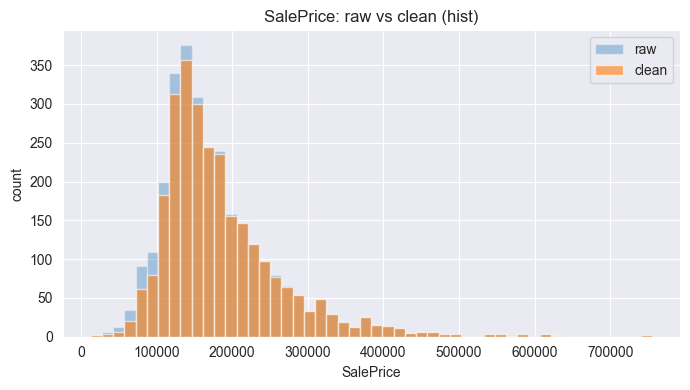

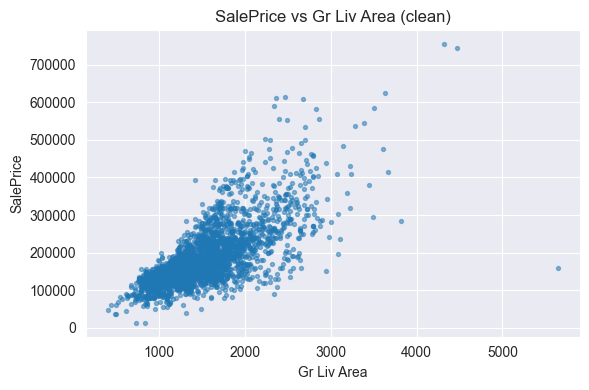

In [37]:
if __name__ == "__main__":
    # Cleaning only (no outlier trimming)
    df_train_20, df_test_20, meta_20 = clean_ames(
        "AmesHousing.csv",
        test_size=0.2,
        random_state=42,
        return_meta=True,
        use_rare_bucket=False,   # stays OFF (safe)
        winsorize=False,         # stays OFF (modeling choice)
        drop_exact_duplicates=True,
        drop_audit_flags=True    # <— recommended ON for modeling
    )
    print("Train 20% shape:", df_train_20.shape, "Test 20% shape:", df_test_20.shape)

    # Report + quick plots
    generate_sanity_report(
        df_raw=pd.read_csv("AmesHousing.csv", sep="\t"),
        df_train_clean=df_train_20,
        df_test_clean=df_test_20,
        meta=meta_20,
        make_plots=True
    )

    # OPTIONAL: TRAIN-ONLY trimming (leak-free)
    # keep_mask = train_band_filter(df_train_20, x_col='Gr Liv Area', y_col='SalePrice', low_q=0.10, high_q=0.90)
    # df_train_band = df_train_20.loc[keep_mask].reset_index(drop=True)
    # print(f"Band-kept rows: {keep_mask.sum()} / {len(keep_mask)} ({keep_mask.mean()*100:.1f}%)")

 Dataset overview

- Raw rows: 2930
- After temporal filters: 2767 rows
  → Dropped 163 rows (5.56%)
  → Reason: impossible chronology (Year Built, Year Remod/Add, Yr Sold, or Garage Yr Blt inconsistent)

- Train/Test split:
  - Train: 2213 rows
  - Test: 554 rows
  - Columns: 89 each

Temporal consistency filters

- Yr Sold ≥ Year Built
- Yr Sold ≥ Year Remod/Add
- Year Remod/Add ≥ Year Built
- Garage Yr Blt between 1880 and Yr Sold + 1

→ 163 rows removed (~5.56%) because they violated at least one rule.

 Basement consistency fixes

- 3 rows corrected where Bsmt Exposure was “NoBasement” but basement area > 0.
  These were changed to “No” and flagged in Fix_BsmtExposure.

- Checked identity:
  Total Bsmt SF == BsmtFin SF 1 + BsmtFin SF 2 + Bsmt Unf SF
  → 0 mismatches after cleaning.

 Missing data profile

 Before cleaning (top 10 columns with missing values)

| Column | Missing count |
|:--|--:|
| Pool QC | 2917 |
| Misc Feature | 2824 |
| Alley | 2732 |
| Fence | 2358 |
| Mas Vnr Type | 1775 |
| Fireplace Qu | 1422 |
| Lot Frontage | 490 |
| Garage Qual | 159 |
| Garage Yr Blt | 159 |
| Garage Cond | 159 |

Most missing values correspond to optional features (pools, fences, alleys).
These were replaced with explicit absence labels like “NoPool”, “NoFence”, “NoGarage”, etc.

### After cleaning (top 10 columns with missing values)

| Column | Missing count |
|:--|--:|
| MS SubClass | 0 |
| MS Zoning | 0 |
| Lot Frontage | 0 |
| Lot Area | 0 |
| Alley | 0 |
| Lot Shape | 0 |
| Land Contour | 0 |
| Lot Config | 0 |
| Land Slope | 0 |
| Neighborhood | 0 |

All missing values have been handled.
No remaining NaN values in either numeric or categorical columns.

SalePrice distribution

| Stage | Rows | Median | Min | Max |
|:--|--:|--:|--:|--:|
| Raw | 2930 | 160000 | 12789 | 755000 |
| Cleaned | 2767 | 165000 | 12789 | 755000 |

Median increased slightly after filtering (160k → 165k),
most likely because invalid or inconsistent low-priced entries were removed.

Sanity summary

| Check | Status | Notes |
|:--|:--|:--|
| Temporal logic | OK | 163 invalid rows removed |
| Basement identity | OK | Totals match parts |
| Garage logic | OK | Invalid years and NaNs fixed |
| Missing data | OK | All filled logically |
| Outliers | To do | Will be handled later (train-only quantile band) |
| Leakage | None | Train/test split before computing stats |
| Dataset balance | OK | 80/20 split consistent |

DONE

* TODO Outlier filtering can be applied later using `train_band_filter()` if needed.*

In [38]:
import os, sys, platform, json, pickle
import pandas as pd
import numpy as np
import xgboost as xgb

RANDOM_STATE = 42

In [39]:
# Step 0.2 — load & clean (lock splits for A and B)

DATA_PATH = "AmesHousing.csv"  # tab-separated
assert os.path.exists(DATA_PATH), f"File not found: {DATA_PATH}"

# Scenario A (80/20)
df_train_A, df_test_A, meta_A = clean_ames(
    DATA_PATH,
    test_size=0.20,
    random_state=RANDOM_STATE,
    return_meta=True,
    use_rare_bucket=False,
    winsorize=False,
    drop_exact_duplicates=True,
    drop_audit_flags=True
)

# Scenario B (90/10)
df_train_B, df_test_B, meta_B = clean_ames(
    DATA_PATH,
    test_size=0.10,
    random_state=RANDOM_STATE,
    return_meta=True,
    use_rare_bucket=False,
    winsorize=False,
    drop_exact_duplicates=True,
    drop_audit_flags=True
)

print("A — shapes:", df_train_A.shape, df_test_A.shape)
print("B — shapes:", df_train_B.shape, df_test_B.shape)


A — shapes: (2213, 89) (554, 89)
B — shapes: (2490, 89) (277, 89)


In [40]:
# Step 0.3 — assertions for both scenarios

def assert_no_nans(df, name):
    nans = df.isna().sum().sum()
    assert nans == 0, f"{name} still has {nans} NaNs"
    return True

def assert_same_columns(df_tr, df_te, tag):
    c1, c2 = list(df_tr.columns), list(df_te.columns)
    assert c1 == c2, f"{tag}: train/test columns differ!"
    return True

def feature_count_ok(df, approx=89):
    n = df.shape[1]
    print(f"- Feature count = {n} (expected ≈ {approx})")
    return n

print("Scenario A checks:")
assert_no_nans(df_train_A, "train_A"); assert_no_nans(df_test_A, "test_A")
assert_same_columns(df_train_A, df_test_A, "A")
nA = feature_count_ok(df_train_A)

print("\nScenario B checks:")
assert_no_nans(df_train_B, "train_B"); assert_no_nans(df_test_B, "test_B")
assert_same_columns(df_train_B, df_test_B, "B")
nB = feature_count_ok(df_train_B)

# Quick expected shape sanity (non-fatal)
print("\n(Non-fatal) Expected shape hints:")
print("- A ~ (2213, 89) train / (554, 89) test")
print("- B ~ (2490, 89) train / (277, 89) test")

print("\nAll Step 0.3 assertions passed!!")


Scenario A checks:
- Feature count = 89 (expected ≈ 89)

Scenario B checks:
- Feature count = 89 (expected ≈ 89)

(Non-fatal) Expected shape hints:
- A ~ (2213, 89) train / (554, 89) test
- B ~ (2490, 89) train / (277, 89) test

All Step 0.3 assertions passed!!


In [41]:
# Step 0.4 — save frozen splits and metadata

OUT_DIR = "L2_artifacts"
os.makedirs(OUT_DIR, exist_ok=True)

# Data splits (CSV to avoid parquet deps)
df_train_A.to_csv(os.path.join(OUT_DIR, "L2_clean_train_A.csv"), index=False)
df_test_A .to_csv(os.path.join(OUT_DIR, "L2_clean_test_A.csv"),  index=False)
df_train_B.to_csv(os.path.join(OUT_DIR, "L2_clean_train_B.csv"), index=False)
df_test_B .to_csv(os.path.join(OUT_DIR, "L2_clean_test_B.csv"),  index=False)

# Meta objects can contain Series/DataFrames; pickle them safely
with open(os.path.join(OUT_DIR, "meta_A.pkl"), "wb") as f:
    pickle.dump(meta_A, f)
with open(os.path.join(OUT_DIR, "meta_B.pkl"), "wb") as f:
    pickle.dump(meta_B, f)

# Feature registry (exclude SalePrice for now; PriceClass will be created in Step 1)
feature_names = [c for c in df_train_A.columns if c != "SalePrice"]
with open(os.path.join(OUT_DIR, "feature_names.json"), "w", encoding="utf-8") as f:
    json.dump(sorted(feature_names), f, indent=2)

# Nice one-screen summary
def rows_after_filters(meta):
    return meta.get("n_after_time", None)

summary = {
    "random_state": RANDOM_STATE,
    "scenario_A": {
        "train_shape": df_train_A.shape,
        "test_shape":  df_test_A.shape,
        "n_features":  df_train_A.shape[1],
        "rows_after_temporal_filters": rows_after_filters(meta_A),
    },
    "scenario_B": {
        "train_shape": df_train_B.shape,
        "test_shape":  df_test_B.shape,
        "n_features":  df_train_B.shape[1],
        "rows_after_temporal_filters": rows_after_filters(meta_B),
    }
}
with open(os.path.join(OUT_DIR, "step0_summary.json"), "w", encoding="utf-8") as f:
    json.dump(summary, f, indent=2)

print("Saved:")
for fn in [
    "L2_clean_train_A.csv","L2_clean_test_A.csv",
    "L2_clean_train_B.csv","L2_clean_test_B.csv",
    "meta_A.pkl","meta_B.pkl",
    "feature_names.json","step0_summary.json"
]:
    print(" -", os.path.join(OUT_DIR, fn))

print("\nStep 0 is complete and splits are FROZEN.")


Saved:
 - L2_artifacts\L2_clean_train_A.csv
 - L2_artifacts\L2_clean_test_A.csv
 - L2_artifacts\L2_clean_train_B.csv
 - L2_artifacts\L2_clean_test_B.csv
 - L2_artifacts\meta_A.pkl
 - L2_artifacts\meta_B.pkl
 - L2_artifacts\feature_names.json
 - L2_artifacts\step0_summary.json

Step 0 is complete and splits are FROZEN.


In [42]:
# Step 0.5 — compact summary printout

def compact_meta(meta):
    n_raw = meta.get("n_raw", None)
    n_after = meta.get("n_after_time", None)
    dropped = None if (n_raw is None or n_after is None) else (n_raw - n_after)
    pct = None if (n_raw in (None, 0) or n_after is None) else 100.0 * dropped / n_raw
    return f"raw={n_raw}, after_filters={n_after}, dropped={dropped} ({pct:.2f}%)"

print("Scenario A:", summary["scenario_A"])
print("Meta A:", compact_meta(meta_A))

print("\nScenario B:", summary["scenario_B"])
print("Meta B:", compact_meta(meta_B))

print("\nNote: From now on, always reload from L2_artifacts/* for fair comparisons.")


Scenario A: {'train_shape': (2213, 89), 'test_shape': (554, 89), 'n_features': 89, 'rows_after_temporal_filters': 2767}
Meta A: raw=2930, after_filters=2767, dropped=163 (5.56%)

Scenario B: {'train_shape': (2490, 89), 'test_shape': (277, 89), 'n_features': 89, 'rows_after_temporal_filters': 2767}
Meta B: raw=2930, after_filters=2767, dropped=163 (5.56%)

Note: From now on, always reload from L2_artifacts/* for fair comparisons.


In [43]:
# Step 1.0 — config & load frozen splits
ART_IN  = "L2_artifacts"   # from Step 0
ART_OUT = "L3_artifacts"   # new folder for Step 1
os.makedirs(ART_OUT, exist_ok=True)

# Load Step 0 splits (Scenario A = 80/20, Scenario B = 90/10)
df_train_A = pd.read_csv(os.path.join(ART_IN, "L2_clean_train_A.csv"))
df_test_A  = pd.read_csv(os.path.join(ART_IN, "L2_clean_test_A.csv"))
df_train_B = pd.read_csv(os.path.join(ART_IN, "L2_clean_train_B.csv"))
df_test_B  = pd.read_csv(os.path.join(ART_IN, "L2_clean_test_B.csv"))

In [44]:
# Step 1.1 — leakage-safe quantile binning
def make_price_classes(train_df: pd.DataFrame,
                       test_df: pd.DataFrame,
                       n_bins: int = 5,
                       price_col: str = "SalePrice",
                       label_name: str = "PriceClass"):
    """
    Create discrete price classes from SalePrice using TRAIN-only quantile cuts,
    then apply the same bin edges to TEST. Returns (train_df2, test_df2, bin_edges).

    - n_bins: e.g., 3 (low/med/high), 4 (quartiles), 5 (quintiles).
    - Adds both an integer label (PriceClass) and the interval text (PriceClassInterval).
    """
    # Compute bin edges on TRAIN ONLY (drop duplicates so qcut doesn't complain)
    q = np.linspace(0, 1, n_bins + 1)
    edges = train_df[price_col].quantile(q).values
    # Ensure strictly increasing edges (handle equal quantiles in heavy ties)
    edges = np.unique(edges)
    if len(edges) - 1 < n_bins:
        # Fallback: make slightly jittered edges if too many ties
        edges = np.linspace(train_df[price_col].min(), train_df[price_col].max(), n_bins + 1)

    # Label on TRAIN
    train_df = train_df.copy()
    train_df[label_name] = pd.cut(train_df[price_col], bins=edges, include_lowest=True, labels=False)
    train_df["PriceClassInterval"] = pd.cut(train_df[price_col], bins=edges, include_lowest=True).astype(str)

    # Apply same edges to TEST
    test_df = test_df.copy()
    test_df[label_name] = pd.cut(test_df[price_col], bins=edges, include_lowest=True, labels=False)
    test_df["PriceClassInterval"] = pd.cut(test_df[price_col], bins=edges, include_lowest=True).astype(str)

    # In rare cases values may fall outside due to numeric eps — clip & relabel
    train_df[label_name] = train_df[label_name].astype("Int64")
    test_df[label_name]  = test_df[label_name].astype("Int64")

    # Safety assertions (no NaNs in labels)
    assert train_df[label_name].isna().sum() == 0, "Train has NaNs in PriceClass"
    assert test_df[label_name].isna().sum() == 0, "Test has NaNs in PriceClass"

    return train_df, test_df, edges


In [45]:
# Step 1.2 — create 5-class target (quintiles) for A and B
N_BINS = 5  # change to 3 or 4 if you prefer

trA_cls, teA_cls, edges_A = make_price_classes(df_train_A, df_test_A, n_bins=N_BINS)
trB_cls, teB_cls, edges_B = make_price_classes(df_train_B, df_test_B, n_bins=N_BINS)

print("Scenario A — PriceClass value counts (train):")
print(trA_cls["PriceClass"].value_counts(normalize=True).sort_index().round(3))

print("\nScenario B — PriceClass value counts (train):")
print(trB_cls["PriceClass"].value_counts(normalize=True).sort_index().round(3))

print("\nBin edges A:", edges_A)
print("Bin edges B:", edges_B)

Scenario A — PriceClass value counts (train):
PriceClass
0    0.202
1    0.202
2    0.197
3      0.2
4      0.2
Name: proportion, dtype: Float64

Scenario B — PriceClass value counts (train):
PriceClass
0      0.2
1    0.201
2      0.2
3    0.198
4      0.2
Name: proportion, dtype: Float64

Bin edges A: [ 12789.  127000.  150000.  181026.8 234150.  755000. ]
Bin edges B: [ 12789. 127000. 149900. 180500. 233284. 755000.]


In [46]:
# Step 1.3 — sanity checks for stratification-like balance across splits
def class_share(df, label="PriceClass"):
    s = df[label].value_counts(normalize=True).sort_index()
    return s.rename(lambda k: f"C{k}")

print("A — train shares:\n", class_share(trA_cls))
print("\nA — test  shares:\n", class_share(teA_cls))

print("\nB — train shares:\n", class_share(trB_cls))
print("\nB — test  shares:\n", class_share(teB_cls))

# Same label set?
assert set(trA_cls["PriceClass"].unique()) == set(teA_cls["PriceClass"].unique()), "A: class mismatch train/test"
assert set(trB_cls["PriceClass"].unique()) == set(teB_cls["PriceClass"].unique()), "B: class mismatch train/test"
print("\nLabel sets match in A and B")

A — train shares:
 PriceClass
C0    0.201536
C1    0.201988
C2    0.196566
C3    0.199729
C4    0.200181
Name: proportion, dtype: Float64

A — test  shares:
 PriceClass
C0    0.198556
C1    0.214801
C2    0.189531
C3    0.194946
C4    0.202166
Name: proportion, dtype: Float64

B — train shares:
 PriceClass
C0    0.200402
C1    0.201205
C2         0.2
C3    0.198394
C4         0.2
Name: proportion, dtype: Float64

B — test  shares:
 PriceClass
C0    0.205776
C1    0.176895
C2    0.173285
C3    0.223827
C4    0.220217
Name: proportion, dtype: Float64

Label sets match in A and B


In [47]:
# Step 1.4 — show SalePrice medians by class (interpretability check)
def price_summary(df):
    return df.groupby("PriceClass")["SalePrice"].agg(["count","median","min","max"]).astype(int)

print("A — train price by class:\n", price_summary(trA_cls))
print("\nA — test  price by class:\n", price_summary(teA_cls))

print("\nB — train price by class:\n", price_summary(trB_cls))
print("\nB — test  price by class:\n", price_summary(teB_cls))

A — train price by class:
             count  median     min     max
PriceClass                               
0             446  110000   12789  127000
1             447  139000  127500  150000
2             435  165500  150500  181000
3             442  203000  181134  234000
4             443  285000  234250  755000

A — test  price by class:
             count  median     min     max
PriceClass                               
0             110  111750   45000  127000
1             119  139000  127500  150000
2             105  165150  152000  181000
3             108  200070  182000  233500
4             112  288801  234500  615000

B — train price by class:
             count  median     min     max
PriceClass                               
0             499  110000   12789  127000
1             501  138500  127500  149900
2             498  165000  150000  180500
3             494  202500  181000  233230
4             498  284000  233500  755000

B — test  price by class:
        

In [48]:
# Step 1.5 — persist L3 artifacts
trA_cls.to_csv(os.path.join(ART_OUT, "L3_cls_train_A.csv"), index=False)
teA_cls.to_csv(os.path.join(ART_OUT, "L3_cls_test_A.csv"),  index=False)
trB_cls.to_csv(os.path.join(ART_OUT, "L3_cls_train_B.csv"), index=False)
teB_cls.to_csv(os.path.join(ART_OUT, "L3_cls_test_B.csv"),  index=False)

# Save bin edges for reproducibility
with open(os.path.join(ART_OUT, "L3_edges_A.json"), "w", encoding="utf-8") as f:
    json.dump([float(x) for x in edges_A], f, indent=2)
with open(os.path.join(ART_OUT, "L3_edges_B.json"), "w", encoding="utf-8") as f:
    json.dump([float(x) for x in edges_B], f, indent=2)

# Save a tiny registry of the new label name
with open(os.path.join(ART_OUT, "L3_label_meta.json"), "w", encoding="utf-8") as f:
    json.dump({
        "label_name": "PriceClass",
        "interval_col": "PriceClassInterval",
        "n_bins": int(N_BINS),
        "note": "Bins computed on TRAIN only; applied to TEST without refit."
    }, f, indent=2)

print("Saved Step 1 artifacts in:", ART_OUT)
for fn in ["L3_cls_train_A.csv","L3_cls_test_A.csv","L3_edges_A.json",
           "L3_cls_train_B.csv","L3_cls_test_B.csv","L3_edges_B.json",
           "L3_label_meta.json"]:
    print(" -", os.path.join(ART_OUT, fn))
print("\nStep 1 complete.")


Saved Step 1 artifacts in: L3_artifacts
 - L3_artifacts\L3_cls_train_A.csv
 - L3_artifacts\L3_cls_test_A.csv
 - L3_artifacts\L3_edges_A.json
 - L3_artifacts\L3_cls_train_B.csv
 - L3_artifacts\L3_cls_test_B.csv
 - L3_artifacts\L3_edges_B.json
 - L3_artifacts\L3_label_meta.json

Step 1 complete.


In [49]:
RANDOM_STATE = 42
ART_IN  = "L3_artifacts"   # created in Step 1
ART_OUT = "L4_artifacts"   # new folder for Step 2
os.makedirs(ART_OUT, exist_ok=True)

# Scenario A (80/20)
trA = pd.read_csv(os.path.join(ART_IN, "L3_cls_train_A.csv"))
teA = pd.read_csv(os.path.join(ART_IN, "L3_cls_test_A.csv"))

# Scenario B (90/10)
trB = pd.read_csv(os.path.join(ART_IN, "L3_cls_train_B.csv"))
teB = pd.read_csv(os.path.join(ART_IN, "L3_cls_test_B.csv"))

# Optional: Show quick shapes
print("A:", trA.shape, teA.shape)
print("B:", trB.shape, teB.shape)


A: (2213, 91) (554, 91)
B: (2490, 91) (277, 91)


In [50]:
# Step 2.1 — define X and y
LABEL_COL = "PriceClass"
DROP_FROM_X = [LABEL_COL, "SalePrice", "PriceClassInterval"]  # interval text exists after Step 1

def split_xy(df: pd.DataFrame):
    cols_x = [c for c in df.columns if c not in DROP_FROM_X]
    X = df[cols_x].copy()
    y = df[LABEL_COL].astype("int64").copy()
    return X, y, cols_x

XA_tr, yA_tr, colsA = split_xy(trA)
XA_te, yA_te, _     = split_xy(teA)

XB_tr, yB_tr, colsB = split_xy(trB)
XB_te, yB_te, _     = split_xy(teB)

print("A — X cols:", len(colsA), "| y classes:", sorted(yA_tr.unique()))
print("B — X cols:", len(colsB), "| y classes:", sorted(yB_tr.unique()))


A — X cols: 88 | y classes: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]
B — X cols: 88 | y classes: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]


In [51]:
# Step 2.2 — dtype audit
def dtype_report(X, tag):
    rep = X.dtypes.value_counts()
    obj_cols = X.select_dtypes(include=["object"]).columns.tolist()
    print(f"\n{tag} dtypes:\n{rep}")
    if obj_cols:
        print(f"{tag} object columns needing OHE: {obj_cols}")
    else:
        print(f"{tag}: no object columns — already numeric")

dtype_report(XA_tr, "A_train")
dtype_report(XA_te, "A_test")
dtype_report(XB_tr, "B_train")
dtype_report(XB_te, "B_test")



A_train dtypes:
int64      42
float64    27
str        19
Name: count, dtype: int64
A_train object columns needing OHE: ['MS Zoning', 'Alley', 'Land Contour', 'Lot Config', 'Neighborhood', 'Condition 1', 'Bldg Type', 'House Style', 'Roof Style', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Foundation', 'Central Air', 'Functional', 'Garage Type', 'Fence', 'Sale Type', 'Sale Condition']

A_test dtypes:
int64      42
float64    27
str        19
Name: count, dtype: int64
A_test object columns needing OHE: ['MS Zoning', 'Alley', 'Land Contour', 'Lot Config', 'Neighborhood', 'Condition 1', 'Bldg Type', 'House Style', 'Roof Style', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Foundation', 'Central Air', 'Functional', 'Garage Type', 'Fence', 'Sale Type', 'Sale Condition']

B_train dtypes:
int64      42
float64    27
str        19
Name: count, dtype: int64
B_train object columns needing OHE: ['MS Zoning', 'Alley', 'Land Contour', 'Lot Config', 'Neighborhood', 'Condition 1', 'Bldg Type'

In [52]:
# Step 2.3 — OHE for object cols (fit on TRAIN), passthrough numeric
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

def make_preprocessor(X_train: pd.DataFrame):
    obj_cols = X_train.select_dtypes(include=["object", "string"]).columns.tolist()
    num_cols = [c for c in X_train.columns if c not in obj_cols]

    if obj_cols:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False, dtype=np.float64)
        pre = ColumnTransformer(
            transformers=[
                ("cat", ohe, obj_cols),
                ("num", "passthrough", num_cols),
            ],
            remainder="drop",
            verbose_feature_names_out=False,
        )
    else:
        # no object columns; identity transformer on all
        pre = ColumnTransformer(
            transformers=[("num", "passthrough", X_train.columns.tolist())],
            remainder="drop",
            verbose_feature_names_out=False,
        )
    return pre

def fit_transform_splits(X_train, X_test):
    Xtr = X_train.copy()
    Xte = X_test.copy()

    obj_cols = Xtr.select_dtypes(include=["object", "string"]).columns
    for c in obj_cols:
        Xtr[c] = Xtr[c].astype(str)
        if c in Xte.columns:
            Xte[c] = Xte[c].astype(str)

    pre = make_preprocessor(Xtr)
    Xtr_m = pre.fit_transform(Xtr)
    Xte_m = pre.transform(Xte)
    feat_names = pre.get_feature_names_out().tolist()
    return Xtr_m, Xte_m, feat_names, pre

# Scenario A
XA_tr_m, XA_te_m, featA, preA = fit_transform_splits(XA_tr, XA_te)
print("A transformed shapes:", XA_tr_m.shape, XA_te_m.shape)

# Scenario B
XB_tr_m, XB_te_m, featB, preB = fit_transform_splits(XB_tr, XB_te)
print("B transformed shapes:", XB_tr_m.shape, XB_te_m.shape)


A transformed shapes: (2213, 221) (554, 221)
B transformed shapes: (2490, 222) (277, 222)


In [53]:
# Step 2.4 — persist arrays and metadata for modeling

# Arrays (npz)
np.savez_compressed(os.path.join(ART_OUT, "A_data.npz"),
                    X_train=XA_tr_m, y_train=yA_tr.values,
                    X_test=XA_te_m, y_test=yA_te.values)
np.savez_compressed(os.path.join(ART_OUT, "B_data.npz"),
                    X_train=XB_tr_m, y_train=yB_tr.values,
                    X_test=XB_te_m, y_test=yB_te.values)

# Feature names
with open(os.path.join(ART_OUT, "A_features.json"), "w", encoding="utf-8") as f:
    json.dump(featA, f, indent=2)
with open(os.path.join(ART_OUT, "B_features.json"), "w", encoding="utf-8") as f:
    json.dump(featB, f, indent=2)

# Save preprocessors (so tree/importance later can be mapped back reliably)
with open(os.path.join(ART_OUT, "A_preprocessor.pkl"), "wb") as f:
    pickle.dump(preA, f)
with open(os.path.join(ART_OUT, "B_preprocessor.pkl"), "wb") as f:
    pickle.dump(preB, f)

# Quick summaries
def class_share(y):
    vc = pd.Series(y).value_counts(normalize=True).sort_index().round(3)
    return vc.rename(lambda k: f"C{k}")

print("\nSaved to:", ART_OUT)
print("A — y_train shares:\n", class_share(yA_tr))
print("A — y_test  shares:\n", class_share(yA_te))
print("\nB — y_train shares:\n", class_share(yB_tr))
print("B — y_test  shares:\n", class_share(yB_te))



Saved to: L4_artifacts
A — y_train shares:
 PriceClass
C0    0.202
C1    0.202
C2    0.197
C3    0.200
C4    0.200
Name: proportion, dtype: float64
A — y_test  shares:
 PriceClass
C0    0.199
C1    0.215
C2    0.190
C3    0.195
C4    0.202
Name: proportion, dtype: float64

B — y_train shares:
 PriceClass
C0    0.200
C1    0.201
C2    0.200
C3    0.198
C4    0.200
Name: proportion, dtype: float64
B — y_test  shares:
 PriceClass
C0    0.206
C1    0.177
C2    0.173
C3    0.224
C4    0.220
Name: proportion, dtype: float64


In [54]:
# Step 4.0 — imports + load arrays
import os, json, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier, plot_tree, plot_importance

ART_IN = "L4_artifacts"
os.makedirs("plots", exist_ok=True)

# Load Scenario A
A = np.load(os.path.join(ART_IN, "A_data.npz"))
XA_tr, yA_tr = A["X_train"], A["y_train"]
XA_te, yA_te = A["X_test"],  A["y_test"]

# Load Scenario B
B = np.load(os.path.join(ART_IN, "B_data.npz"))
XB_tr, yB_tr = B["X_train"], B["y_train"]
XB_te, yB_te = B["X_test"],  B["y_test"]

print("A:", XA_tr.shape, XA_te.shape)
print("B:", XB_tr.shape, XB_te.shape)


A: (2213, 221) (554, 221)
B: (2490, 222) (277, 222)


In [55]:
# Step 4.1 — baseline XGBoost for A and B (clean params)
from xgboost import XGBClassifier

N_CLASSES = len(np.unique(yA_tr))  # same for B in our setup

BASE_PARAMS = dict(
    objective="multi:softprob",      # multiclass probabilities
    eval_metric="mlogloss",          # you can also add "merror" to see error rate
    random_state=42,
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=1.0,
    colsample_bytree=1.0,
    # optional but explicit:
    num_class=N_CLASSES,
    # optional speedups:
    tree_method="hist",              # or "gpu_hist" if you have a GPU
    verbosity=0                      # quieten training logs
)

model_A = XGBClassifier(**BASE_PARAMS)
model_B = XGBClassifier(**BASE_PARAMS)

print("Training Scenario A (80/20)...")
model_A.fit(XA_tr, yA_tr)

print("Training Scenario B (90/10)...")
model_B.fit(XB_tr, yB_tr)


Training Scenario A (80/20)...
Training Scenario B (90/10)...


,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,1.0
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'



=== Scenario A (80/20) Results ===
Accuracy: 0.738 | Precision: 0.742 | Recall: 0.738 | F1: 0.739

Classification Report:
               precision    recall  f1-score   support

           0      0.766     0.773     0.769       110
           1      0.609     0.655     0.632       119
           2      0.681     0.590     0.633       105
           3      0.739     0.815     0.775       108
           4      0.914     0.857     0.885       112

    accuracy                          0.738       554
   macro avg      0.742     0.738     0.739       554
weighted avg      0.741     0.738     0.738       554



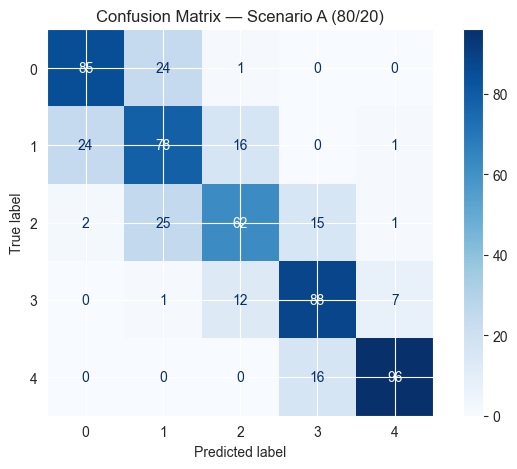


=== Scenario B (90/10) Results ===
Accuracy: 0.733 | Precision: 0.733 | Recall: 0.725 | F1: 0.726

Classification Report:
               precision    recall  f1-score   support

           0      0.857     0.737     0.792        57
           1      0.528     0.571     0.549        49
           2      0.569     0.688     0.623        48
           3      0.793     0.742     0.767        62
           4      0.915     0.885     0.900        61

    accuracy                          0.733       277
   macro avg      0.733     0.725     0.726       277
weighted avg      0.747     0.733     0.738       277



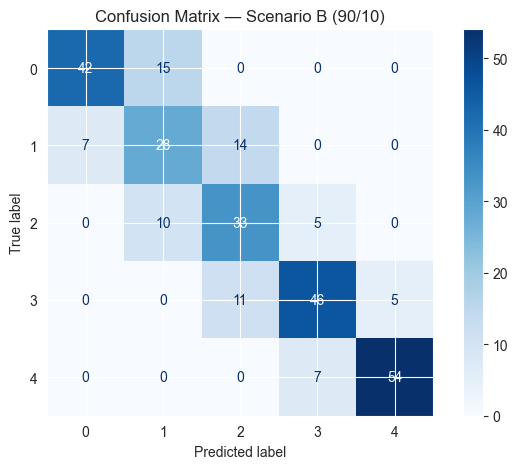

In [56]:
# Step 4.2 — compute metrics and reports
def evaluate_model(model, Xtr, ytr, Xte, yte, tag):
    print(f"\n=== {tag} Results ===")
    y_pred = model.predict(Xte)
    acc  = accuracy_score(yte, y_pred)
    prec = precision_score(yte, y_pred, average="macro")
    rec  = recall_score(yte, y_pred, average="macro")
    f1   = f1_score(yte, y_pred, average="macro")
    print(f"Accuracy: {acc:.3f} | Precision: {prec:.3f} | Recall: {rec:.3f} | F1: {f1:.3f}")
    print("\nClassification Report:\n", classification_report(yte, y_pred, digits=3))
    cm = confusion_matrix(yte, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix — {tag}")
    plt.tight_layout()
    plt.show()

evaluate_model(model_A, XA_tr, yA_tr, XA_te, yA_te, "Scenario A (80/20)")
evaluate_model(model_B, XB_tr, yB_tr, XB_te, yB_te, "Scenario B (90/10)")


<Figure size 1200x800 with 0 Axes>

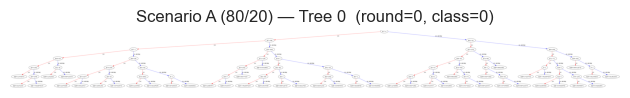

<Figure size 1200x800 with 0 Axes>

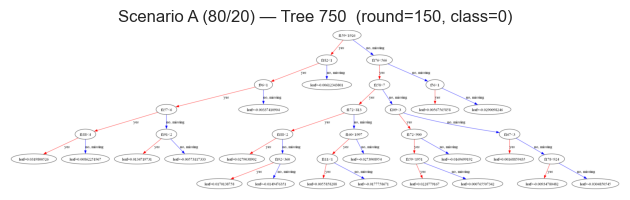

<Figure size 1200x800 with 0 Axes>

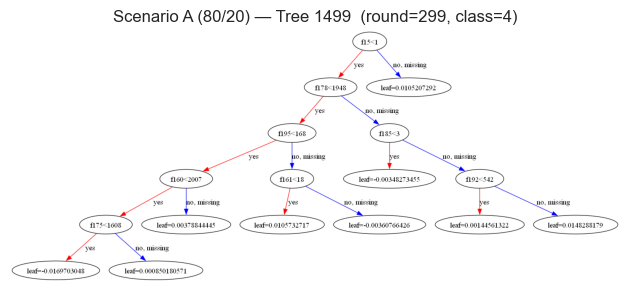

<Figure size 1200x800 with 0 Axes>

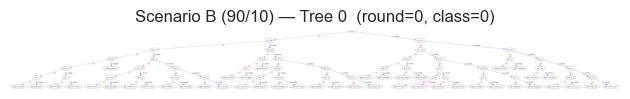

<Figure size 1200x800 with 0 Axes>

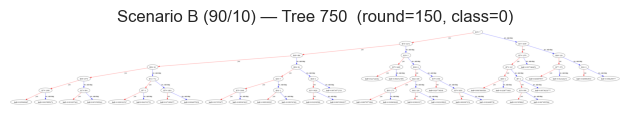

<Figure size 1200x800 with 0 Axes>

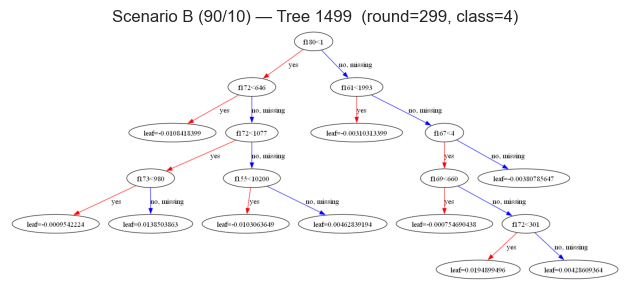

In [57]:
# Step 4.3 — robust tree plotting for multiclass (no early stopping)
import numpy as np
import matplotlib.pyplot as plt
from xgboost import plot_tree

def plot_some_trees(model, tag, which=("first", "middle", "last")):
    """
    Plot a few trees from a trained XGBClassifier, handling:
    - No early stopping (no best_iteration)
    - Multiclass (num_class trees per boosting round)
    """
    booster = model.get_booster()

    # Number of boosting rounds actually used:
    n_rounds = booster.num_boosted_rounds()  # ok with or without early stopping

    # Number of classes (multiclass has one tree per class per round)
    try:
        n_classes = len(model.classes_)
    except Exception:
        n_classes = int(booster.attr("num_class") or 1)

    total_trees = n_rounds * n_classes

    def idx_pick(key):
        if key == "first":
            return 0
        if key == "middle":
            return max(0, total_trees // 2)
        if key == "last":
            return total_trees - 1
        # allow explicit numeric index
        return int(key)

    for key in which:
        idx = idx_pick(key)
        round_idx = idx // n_classes
        class_idx = idx % n_classes

        plt.figure(figsize=(12, 8))
        # Use tree_idx to avoid FutureWarning on num_trees
        plot_tree(model, tree_idx=idx)
        plt.title(f"{tag} — Tree {idx}  (round={round_idx}, class={class_idx})")
        plt.tight_layout()
        plt.show()

# Usage:
plot_some_trees(model_A, "Scenario A (80/20)")
plot_some_trees(model_B, "Scenario B (90/10)")


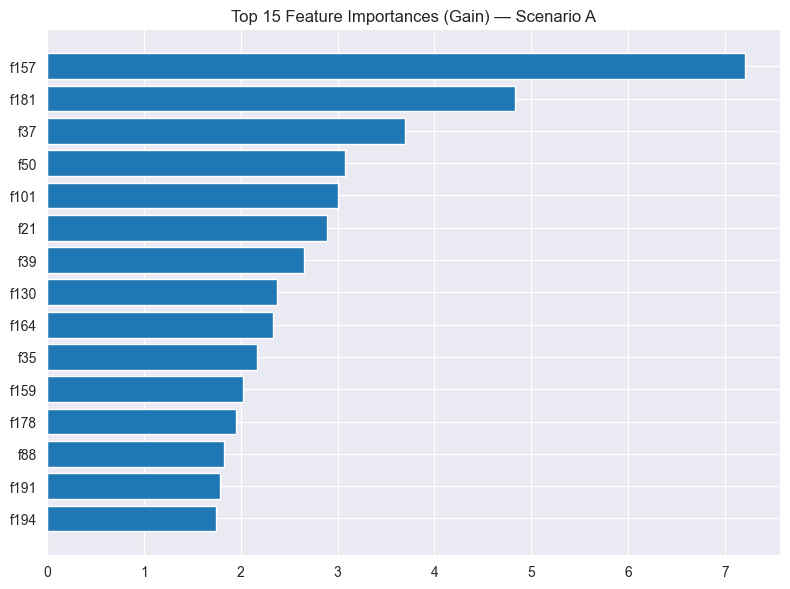

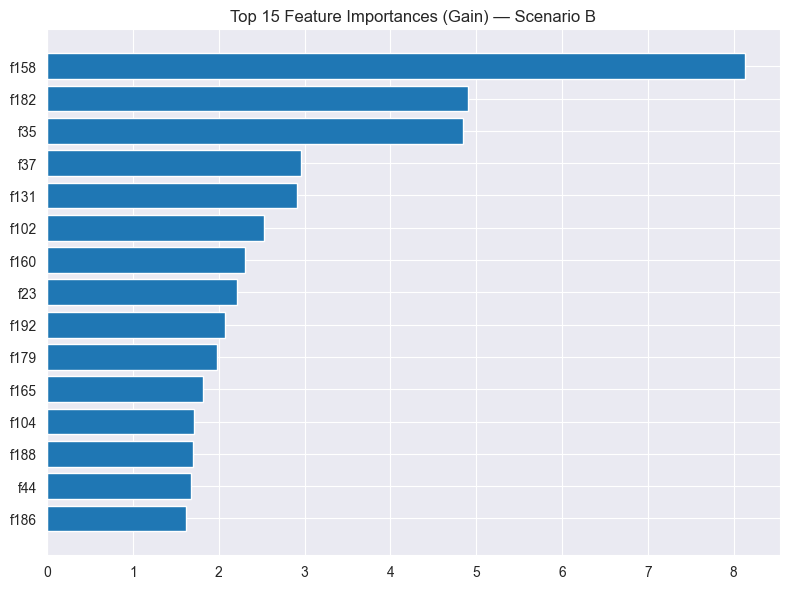

In [58]:
# Step 4.4 — feature importance (top 15)
with open(os.path.join("L4_artifacts","A_features.json"),"r") as f:
    featA = json.load(f)
with open(os.path.join("L4_artifacts","B_features.json"),"r") as f:
    featB = json.load(f)

def top_importance(model, feature_names, tag, topn=15):
    booster = model.get_booster()
    imp = booster.get_score(importance_type="gain")
    df = pd.DataFrame(list(imp.items()), columns=["Feature","Gain"])
    df = df.sort_values("Gain", ascending=False).head(topn)
    plt.figure(figsize=(8,6))
    plt.barh(df["Feature"], df["Gain"])
    plt.gca().invert_yaxis()
    plt.title(f"Top {topn} Feature Importances (Gain) — {tag}")
    plt.tight_layout()
    plt.show()
    return df

impA = top_importance(model_A, featA, "Scenario A")
impB = top_importance(model_B, featB, "Scenario B")


In [59]:
# Step 5 — Cross-validation on the training set (A: k=5, B: k=10)
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier

def cv_scores(X, y, k, params):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    rows = []
    for fold, (tr, va) in enumerate(skf.split(X, y), 1):
        clf = XGBClassifier(**params)
        clf.fit(X[tr], y[tr])
        yp = clf.predict(X[va])
        rows.append({
            "fold": fold,
            "acc": accuracy_score(y[va], yp),
            "prec": precision_score(y[va], yp, average="macro"),
            "rec":  recall_score(y[va], yp, average="macro"),
            "f1":   f1_score(y[va], yp, average="macro"),
        })
    df = pd.DataFrame(rows)
    return df, df.mean(numeric_only=True).to_dict()

# Use the same BASE_PARAMS you trained with
print("CV — Scenario A (80/20), k=5")
cvA_df, cvA_mean = cv_scores(XA_tr, yA_tr, k=5, params=BASE_PARAMS)
display(cvA_df); print("Mean:", {k: round(v,3) for k, v in cvA_mean.items()})

print("\nCV — Scenario B (90/10), k=10")
cvB_df, cvB_mean = cv_scores(XB_tr, yB_tr, k=10, params=BASE_PARAMS)
display(cvB_df); print("Mean:", {k: round(v,3) for k, v in cvB_mean.items()})

CV — Scenario A (80/20), k=5


,fold,acc,prec,rec,f1
0,1,0.717833,0.722724,0.717500,0.718485
1,2,0.672686,0.672811,0.672502,0.672405
2,3,0.729120,0.729525,0.728577,0.727934
3,4,0.699095,0.701971,0.698241,0.698932
4,5,0.701357,0.697604,0.700667,0.698283


Mean: {'fold': 3.0, 'acc': 0.704, 'prec': 0.705, 'rec': 0.703, 'f1': 0.703}

CV — Scenario B (90/10), k=10


,fold,acc,prec,rec,f1
0,1,0.734940,0.736970,0.735837,0.734939
1,2,0.718876,0.719667,0.719673,0.719178
2,3,0.690763,0.694257,0.690776,0.692014
3,4,0.714859,0.721167,0.714694,0.716680
4,5,0.710843,0.708229,0.710612,0.707529
5,6,0.726908,0.727688,0.727102,0.725471
6,7,0.686747,0.692449,0.686694,0.687703
7,8,0.746988,0.745494,0.746401,0.744295
8,9,0.746988,0.748473,0.746449,0.747083
9,10,0.698795,0.703587,0.699347,0.698576


Mean: {'fold': 5.5, 'acc': 0.718, 'prec': 0.72, 'rec': 0.718, 'f1': 0.717}


In [60]:
# Step 6 — Data-prep strategy comparison
from types import SimpleNamespace

def run_strategy(tag, test_size, use_rare_bucket=False, winsorize=False, band_filter=False):
    # Clean with toggles
    df_tr, df_te, meta = clean_ames(
        DATA_PATH, test_size=test_size, random_state=RANDOM_STATE,
        return_meta=True, use_rare_bucket=use_rare_bucket, winsorize=winsorize,
        drop_exact_duplicates=True, drop_audit_flags=True
    )

    # Make labels (quintiles) on TRAIN only
    tr_cls, te_cls, _ = make_price_classes(df_tr, df_te, n_bins=5)

    # X/y split
    def split_xy(df):
        X = df.drop(columns=["SalePrice","PriceClass","PriceClassInterval"], errors="ignore")
        y = df["PriceClass"].astype("int64")
        return X, y

    Xtr, ytr = split_xy(tr_cls); Xte, yte = split_xy(te_cls)

    # Build preprocessor from TRAIN and transform
    Xtr_m, Xte_m, feats, pre = fit_transform_splits(Xtr, Xte)

    # Train XGB baseline
    clf = XGBClassifier(**BASE_PARAMS)
    clf.fit(Xtr_m, ytr)
    yp = clf.predict(Xte_m)

    res = {
        "tag": tag,
        "acc": accuracy_score(yte, yp),
        "prec": precision_score(yte, yp, average="macro"),
        "rec":  recall_score(yte, yp, average="macro"),
        "f1":   f1_score(yte, yp, average="macro"),
        "n_train": len(Xtr), "n_test": len(Xte)
    }

    # Optional train-only band filter
    if band_filter and {'Gr Liv Area','SalePrice'} <= set(tr_cls.columns):
        keep = train_band_filter(tr_cls, 'Gr Liv Area', 'SalePrice', 0.10, 0.90)
        tr_band = tr_cls.loc[keep].reset_index(drop=True)
        Xtr_b, ytr_b = split_xy(tr_band)
        Xtr_bm = pre.fit_transform(Xtr_b)  # refit preprocessor on the trimmed TRAIN
        Xte_bm = pre.transform(Xte)
        clf_b = XGBClassifier(**BASE_PARAMS)
        clf_b.fit(Xtr_bm, ytr_b)
        yp_b = clf_b.predict(Xte_bm)
        res.update({
            "band_acc": accuracy_score(yte, yp_b),
            "band_prec": precision_score(yte, yp_b, average="macro"),
            "band_rec":  recall_score(yte, yp_b, average="macro"),
            "band_f1":   f1_score(yte, yp_b, average="macro"),
            "n_train_band": len(Xtr_b)
        })

    return SimpleNamespace(**res)

results = []
# Scenario A (80/20)
results.append(run_strategy("A: baseline", 0.20, use_rare_bucket=False, winsorize=False, band_filter=False))
results.append(run_strategy("A: rare_bucket", 0.20, use_rare_bucket=True,  winsorize=False, band_filter=False))
results.append(run_strategy("A: winsorize",   0.20, use_rare_bucket=False, winsorize=True,  band_filter=False))
results.append(run_strategy("A: band_filter", 0.20, use_rare_bucket=False, winsorize=False, band_filter=True))

# Scenario B (90/10)
results.append(run_strategy("B: baseline", 0.10, use_rare_bucket=False, winsorize=False, band_filter=False))
results.append(run_strategy("B: rare_bucket", 0.10, use_rare_bucket=True,  winsorize=False, band_filter=False))
results.append(run_strategy("B: winsorize",   0.10, use_rare_bucket=False, winsorize=True,  band_filter=False))
results.append(run_strategy("B: band_filter", 0.10, use_rare_bucket=False, winsorize=False, band_filter=True))

comp = pd.DataFrame([r.__dict__ for r in results])
display(comp.sort_values("f1", ascending=False))

C:\Users\scoti\AppData\Local\Temp\ipykernel_8040\444509671.py:61: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_tr[c] = df_tr[c].clip(lower=q_lo.get(c, df_tr[c].min()), upper=q_hi.get(c, df_tr[c].max()))
C:\Users\scoti\AppData\Local\Temp\ipykernel_8040\444509671.py:64: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_

,tag,acc,prec,rec,f1,n_train,n_test,band_acc,band_prec,band_rec,band_f1,n_train_band
1,A: rare_bucket,0.745487,0.747071,0.745973,0.746106,2213,554,NaN,NaN,NaN,NaN,NaN
0,A: baseline,0.738267,0.742048,0.738125,0.738717,2213,554,NaN,NaN,NaN,NaN,NaN
3,A: band_filter,0.738267,0.742048,0.738125,0.738717,2213,554,0.705776,0.713649,0.707064,0.708223,1771.0
6,B: winsorize,0.736462,0.737978,0.729160,0.731071,2490,277,NaN,NaN,NaN,NaN,NaN
5,B: rare_bucket,0.732852,0.739802,0.726171,0.728549,2490,277,NaN,NaN,NaN,NaN,NaN
4,B: baseline,0.732852,0.732554,0.724590,0.726156,2490,277,NaN,NaN,NaN,NaN,NaN
7,B: band_filter,0.732852,0.732554,0.724590,0.726156,2490,277,0.725632,0.725018,0.714762,0.716986,1994.0
2,A: winsorize,0.725632,0.728544,0.725893,0.725604,2213,554,NaN,NaN,NaN,NaN,NaN


In [61]:
# Step 7 — Manual hyperparameter experiments (gridlite)
from sklearn.model_selection import ParameterGrid

def grid_search_quick(Xtr, ytr, Xte, yte, grid, base=BASE_PARAMS, tag="A"):
    rows = []
    for p in ParameterGrid(grid):
        params = base.copy(); params.update(p)
        clf = XGBClassifier(**params)
        clf.fit(Xtr, ytr)
        yp = clf.predict(Xte)
        rows.append({
            **p,
            "acc":  accuracy_score(yte, yp),
            "prec": precision_score(yte, yp, average="macro"),
            "rec":  recall_score(yte, yp, average="macro"),
            "f1":   f1_score(yte, yp, average="macro"),
        })
    df = pd.DataFrame(rows).sort_values("f1", ascending=False)
    print(f"\n{tag} — grid results (top):")
    display(df.head(10))
    return df

grid = {
    "max_depth": [4, 6, 8],
    "learning_rate": [0.05, 0.1, 0.2],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "n_estimators": [200, 300, 500],
}

dfA_grid = grid_search_quick(XA_tr, yA_tr, XA_te, yA_te, grid, BASE_PARAMS, tag="A (80/20)")
dfB_grid = grid_search_quick(XB_tr, yB_tr, XB_te, yB_te, grid, BASE_PARAMS, tag="B (90/10)")


A (80/20) — grid results (top):


,colsample_bytree,learning_rate,max_depth,n_estimators,subsample,acc,prec,rec,f1
8,0.8,0.05,6,300,0.8,0.745487,0.749903,0.745711,0.747066
3,0.8,0.05,4,300,1.0,0.741877,0.748279,0.741884,0.743710
18,0.8,0.10,4,200,0.8,0.741877,0.746233,0.742778,0.743671
2,0.8,0.05,4,300,0.8,0.740072,0.745255,0.740840,0.742369
20,0.8,0.10,4,300,0.8,0.740072,0.746345,0.740547,0.742244
12,0.8,0.05,8,200,0.8,0.740072,0.742920,0.740419,0.741498
36,0.8,0.20,4,200,0.8,0.740072,0.741929,0.740807,0.740904
62,1.0,0.05,6,300,0.8,0.738267,0.744324,0.738469,0.740039
0,0.8,0.05,4,200,0.8,0.738267,0.743565,0.738317,0.739886
66,1.0,0.05,8,200,0.8,0.738267,0.744240,0.738279,0.739819



B (90/10) — grid results (top):


,colsample_bytree,learning_rate,max_depth,n_estimators,subsample,acc,prec,rec,f1
22,0.8,0.10,4,500,0.8,0.758123,0.758556,0.751429,0.753079
48,0.8,0.20,8,200,0.8,0.758123,0.760759,0.750601,0.752969
4,0.8,0.05,4,500,0.8,0.758123,0.757373,0.749884,0.752024
37,0.8,0.20,4,200,1.0,0.758123,0.756922,0.749311,0.751664
54,1.0,0.05,4,200,0.8,0.754513,0.750967,0.745940,0.747686
73,1.0,0.10,4,200,1.0,0.754513,0.751871,0.745427,0.747531
39,0.8,0.20,4,300,1.0,0.750903,0.751025,0.743234,0.745320
21,0.8,0.10,4,300,1.0,0.750903,0.749557,0.743517,0.745188
7,0.8,0.05,6,200,1.0,0.750903,0.748704,0.744143,0.745103
0,0.8,0.05,4,200,0.8,0.750903,0.749469,0.742721,0.744799


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017911 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3685
[LightGBM] [Info] Number of data points in the train set: 2213, number of used features: 157
[LightGBM] [Info] Start training from score -1.601785
[LightGBM] [Info] Start training from score -1.599546
[LightGBM] [Info] Start training from score -1.626758
[LightGBM] [Info] Start training from score -1.610794
[LightGBM] [Info] Start training from score -1.608535
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

C:\Users\scoti\PycharmProjects\ML_Projects\Lab1_ML\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LGBM A — acc/prec/rec/f1: 0.7184115523465704 0.7217455024818464 0.7186053815465581 0.7190843925739643


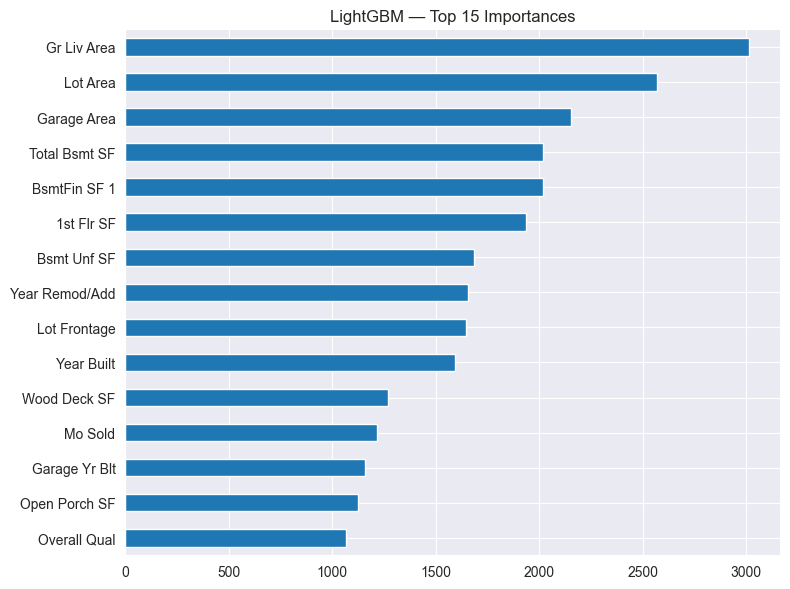

In [66]:
import lightgbm as lgb
lgbm_params = dict(
    objective="multiclass",
    num_class=5,
    learning_rate=0.1,
    n_estimators=300,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
lgbm_A = lgb.LGBMClassifier(**lgbm_params)
lgbm_A.fit(XA_tr, yA_tr)
yp = lgbm_A.predict(XA_te)
print("LGBM A — acc/prec/rec/f1:",
      accuracy_score(yA_te, yp),
      precision_score(yA_te, yp, average="macro"),
      recall_score(yA_te, yp, average="macro"),
      f1_score(yA_te, yp, average="macro"))
# Feature importance
import matplotlib.pyplot as plt
imp = pd.Series(lgbm_A.feature_importances_, index=[*featA]).sort_values(ascending=False).head(15)
plt.figure(figsize=(8,6)); imp.plot(kind="barh"); plt.gca().invert_yaxis()
plt.title("LightGBM — Top 15 Importances"); plt.tight_layout(); plt.show()